In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import ntpath

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
import cv2

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

Using TensorFlow backend.


## Lectura del fichero CSV
Vamos a suponer que no se ha cambiado el nombre del fichero csv generado en el simulador, y que se encuentra en la misma carpeta que este Notebook.

In [2]:
def lee_csv():
    #Lectura en crudo del fichero CSV generado, añadiendo los labels a cada columna
    columnas = ['centro', 'izquierda', 'derecha', 'angulo', 'acelerador', 'freno', 'velocidad']
    datos = pd.read_csv('driving_log.csv', names = columnas)

    return datos

## Renombre de la ruta de las imágenes
Se elimina la ruta absoluta de las imágenes, de esta forma el dataset puede ser usado en diferentes máquinas y/o en diferentes carpetas.

In [3]:
def renombra_imagenes(datos):
    #Modificación de las 3 primeras columnas, correspondiente a la ruta de las imágenes
    datos['centro'] = datos['centro'].apply(get_tail)
    datos['izquierda'] = datos['izquierda'].apply(get_tail)
    datos['derecha'] = datos['derecha'].apply(get_tail)
    
    return datos

#Función para obtener la 'hoja' del árbol perteneciente a la ruta absoluta de la imagen, que corresponde con su nombre
def get_tail(path):
    head, tail = ntpath.split(path) #Separando por "/", tail es el último elemento, y head todo lo anterior
    
    return tail

## Funciones de generación y dibujado del histograma

In [4]:
def genera_histograma(datos, num_bins):
    #Generación del histograma (sus variables serán usadas en la celda siguiente para procesar los elementos sobrantes)
    hist, bins = np.histogram(datos['angulo'], num_bins)
    return hist, bins

def dibuja_histograma(datos, num_bins, max_muestras_por_bin=0):
    #Dibujado del histograma
    plt.hist(datos['angulo'], num_bins)

    plt.xlabel('Ángulo')
    plt.ylabel('Frecuencia')
    plt.title("Distribución de los ángulos") 

    if max_muestras_por_bin != 0:
        #Línea representando max_muestras_por_bin sobre el histograma
        plt.plot((np.min(datos['angulo']), np.max(datos['angulo'])), (max_muestras_por_bin, max_muestras_por_bin))

    plt.show()

## Balanceo del dataset

In [5]:
#-------------BALANCEO DEL DATASET------------------------
def balancea_dataset(datos, num_bins, bins, max_muestras_por_bin):
    datos_preprocesados = datos.copy() #Copia del dataset original
    elementos_a_eliminar = []

    #Recorrido de cada bin
    for i in range(num_bins):
      lista = []
    #Recorrido de cada elemento del dataset: si el ángulo pertenece al bin que estamos recorriendo, lo 
    #metemos en la lista
      for j in range(len(datos['angulo'])):
        if datos['angulo'][j] >= bins[i] and datos['angulo'][j] <= bins[i+1]:
          lista.append(j)

    #Mezclamos los elementos que pertenecen al bin
      lista = shuffle(lista)
      #Nos quedamos con las "sobras" basado en el umbral que hayamos decidido (max_muestras_por_bin), para posteriormente
      #añadirlo a elementos_a_eliminar y utilizarla como lista con los elementos a eliminar en el dataset
      lista = lista[max_muestras_por_bin:]
      elementos_a_eliminar.extend(lista)

    #Eliminamos dichos datos del dataset
    datos_preprocesados.drop(datos_preprocesados.index[elementos_a_eliminar], inplace=True)
    
    return datos_preprocesados

## Función para devolver solo las imágenes y los ángulos del dataset

In [6]:
#Obtención de las imágenes y sus ángulos del dataset
def get_imgs_y_angulos(datos):
    imagenes = []
    angulos = []
    for i in range(len(datos)):
        elemento = datos.iloc[i]
        
        imagen_centro = elemento[0]
        imagenes.append(os.path.join('IMG/', imagen_centro))
        angulo = elemento[3]
        angulos.append(angulo)
        
    imagenes = np.asarray(imagenes)
    angulos = np.asarray(angulos)
    
    return imagenes, angulos

## División del dataset en conjuntos de entrenamiento y prueba

In [7]:
#División del dataset en conjuntos de entrenamiento y prueba
def divide_dataset(imagenes, angulos):
    x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(imagenes, angulos, train_size=0.8)
    
    return x_entrenamiento, x_test, y_entrenamiento, y_test

## Funciones para la transformación de imágenes

In [8]:
#-----CONJUNTO DE FUNCIONES PARA EL PREPROCESAMIENTO DE IMÁGENES----
def recorte(img):
    img = img[70:135,:,:] 
    return img

def RGBaYUV(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) 
    return img

def RGBaGRAY(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def redimensionar_imagen(img, x, y):
    img = cv2.resize(img, (x, y))
    return img

def normalizar_imagen(img):
    img = img/255
    return img

## Preprocesamiento de imágenes necesario para cada arquitectura neuronal

In [9]:
#Función de preprocesamiento de imágenes para el modelo de LeNet-5
def img_preproceso_lenet5(img):
    img = mpimg.imread(img)
    
    img = recorte(img)
    img = RGBaGRAY(img)
    img = redimensionar_imagen(img, 32, 32)
    img = img[:, :, np.newaxis]
    img = normalizar_imagen(img)
    return img

#Función de preprocesamiento de imágenes para el modelo de NVIDIA
def img_preproceso_nvidia(img):
    img = mpimg.imread(img)
    
    img = recorte(img)
    img = RGBaYUV(img)
    img = redimensionar_imagen(img, 200, 66)
    img = normalizar_imagen(img)
    return img

## Funciones para realizar las transformaciones a todas las imágenes del dataset en función de la arquitectura neuronal

In [10]:
#Procesamiento de todas las imágenes de los subconjuntos x_entrenamiento y x_test 

#Procesamiento para el modelo LeNet-5
def preproceso_dataset_lenet5(x_entrenamiento, x_test):
    x_entrenamiento = np.array([img_preproceso_lenet5(x) for x in x_entrenamiento])
    x_test = np.array([img_preproceso_lenet5(x) for x in x_test])
    
    return x_entrenamiento, x_test
    

#Procesamiento para el modelo NVIDIA
def preproceso_dataset_nvidia(x_entrenamiento, x_test):
    x_entrenamiento = np.array([img_preproceso_nvidia(x) for x in x_entrenamiento])
    x_test = np.array([img_preproceso_nvidia(x) for x in x_test])
    
    return x_entrenamiento, x_test

## Definición de los dos modelos neuronales

In [11]:
def crea_modelo_lenet5():
    modelo = Sequential()

    modelo.add(Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1)))
    modelo.add(MaxPooling2D(pool_size=(2, 2)))

    modelo.add(Conv2D(16, (5, 5), activation='relu'))
    modelo.add(MaxPooling2D(pool_size=(2, 2)))

    modelo.add(Conv2D(120, (5, 5), activation='relu'))
    
    modelo.add(Flatten())

    modelo.add(Dense(84, activation='relu'))

    modelo.add(Dense(1))
    
    optimizador = Adam(lr=1e-3)
    modelo.compile(loss='mse', optimizer=optimizador)
    
    return modelo


def crea_modelo_nvidia():
    modelo = Sequential()
    
    modelo.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='relu'))
    modelo.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
    modelo.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
    modelo.add(Conv2D(64, (3, 3), activation='relu'))
    modelo.add(Conv2D(64, (3, 3), activation='relu'))
    
    modelo.add(Flatten())
    
    modelo.add(Dense(100, activation='relu'))
    modelo.add(Dense(50, activation='relu'))
    modelo.add(Dense(10, activation='relu'))
    modelo.add(Dense(1))
    
    optimizador = Adam(lr=1e-3)
    modelo.compile(loss='mse', optimizer=optimizador)
    
    return modelo

## Entrenamiento del modelo

In [12]:
def entrena_modelo(modelo, x_entrenamiento, y_entrenamiento, x_test, y_test, epochs, batch_size):
    entrenamiento = modelo.fit(x_entrenamiento, y_entrenamiento, epochs=epochs, validation_data=(x_test, y_test), 
                       batch_size=batch_size, verbose=1, shuffle=1)
    
    return entrenamiento

## Representación de valores de loss de un entrenamiento

In [13]:
def representa_loss(entrenamiento):
    plt.plot(entrenamiento.history['loss'])
    plt.plot(entrenamiento.history['val_loss'])

    plt.legend(['Entrenamiento', 'Validación'])
    plt.title('Loss')
    plt.xlabel('Época')

    plt.show()

***
# Pruebas
Para llevar a cabo las pruebas, hay que ejecutar antes todas las celdas superiores.

## Prueba 4: Creación de modelo NVIDIA

In [14]:
def prueba4():
    print("--Prueba 4: Creación del modelo NVIDIA--\n")
    
    try:
        print("Creación del modelo...\n")
        modelo = crea_modelo_nvidia()
    except:
        print("Error al crear el modelo.")
        raise
    print("El modelo de NVIDIA se ha creado correctamente.")
    
    print("\nEstructura del modelo creado:")
    print(modelo.summary())
    print("\nClase del modelo: {}".format(type(modelo)))

In [15]:
prueba4()

--Prueba 4: Creación del modelo NVIDIA--

Creación del modelo...

El modelo de NVIDIA se ha creado correctamente.

Estructura del modelo creado:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0       

## Prueba 5: Creación de modelo LeNet-5

In [16]:
def prueba5():
    print("--Prueba 5: Creación del modelo LeNet-5--\n")
    
    try:
        print("Creación del modelo...\n")
        modelo = crea_modelo_lenet5()
    except:
        print("Error al crear el modelo.")
        raise
    print("El modelo de LeNet-5 se ha creado correctamente.")
    
    print("\nEstructura del modelo creado:")
    print(modelo.summary())
    print("\nClase del modelo: {}".format(type(modelo)))

In [17]:
prueba5()

--Prueba 5: Creación del modelo LeNet-5--

Creación del modelo...

El modelo de LeNet-5 se ha creado correctamente.

Estructura del modelo creado:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 120)               0     

## Prueba 6: Entrenamiento del modelo NVIDIA

In [18]:
#Prerrequisitos: dataset con preprocesamiento básico
num_bins = 23
max_muestras_por_bin = 300

dataset = lee_csv()
datos_renombrados = renombra_imagenes(dataset)
hist, bins = genera_histograma(datos_renombrados, num_bins)

dataset_preprocesado = balancea_dataset(datos_renombrados, num_bins, bins, max_muestras_por_bin)

In [19]:
def prueba6(dataset_preprocesado, epochs, batch_size):
    print("--Prueba 6: Entrenamiento del modelo NVIDIA--\n")
    
    try:
        print("Obtención de las imágenes y sus ángulos del dataset...\n")
        imgs, angulos = get_imgs_y_angulos(dataset_preprocesado)
    except:
        print("Error al obtener las imágenes y sus ángulos.")
        raise
    print("Las imágenes y sus ángulos se han leído correctamente.")
    
    try:
        print("\nDivisión del dataset en conjuntos de entrenamiento (80%) y validación (20%)...\n")
        x_entrenamiento, x_test, y_entrenamiento, y_test = divide_dataset(imgs, angulos)
    except:
        print("Error al dividir el dataset.")
        raise
    print("División realizada correctamente.\n")
    
    tamano_dataset = len(dataset_preprocesado)
    tamano_entrenamiento = len(x_entrenamiento)
    tamano_validacion = len(x_test)
    print("Tamaño del dataset antes de dividirse: {}".format(tamano_dataset))
    print("\nTamaño del subconjunto de entrenamiento: {}, un {}%".format(tamano_entrenamiento, 
                                                                         round((tamano_entrenamiento/tamano_dataset) * 100)))
    print("\nTamaño del subconjunto de validación: {}, un {}%".format(tamano_validacion, 
                                                                      round((tamano_validacion/tamano_dataset) * 100)))
    
    try:
        print("\nPreprocesamiento de las imágenes de ambos conjuntos para adaptarlas a los requisitos del modelo de NVIDIA...\n")
        x_entrenamiento, x_test = preproceso_dataset_nvidia(x_entrenamiento, x_test)
    except:
        print("Error al preprocesar todas las imágenes.")
        raise
    print("Preprocesamiento de imágenes realizado correctamente.\n")
    
    try:
        print("Muestra del procesamiento realizado sobre una imagen al azar en ambos conjuntos...\n")
        num_random_entrenamiento = random.randrange(0, len(x_entrenamiento))
        num_random_validacion = random.randrange(0, len(x_test))
        img_entrenamiento = x_entrenamiento[num_random_entrenamiento]
        img_validacion = x_test[num_random_validacion]
        
        print("Imagen aleatoria del conjunto de entrenamiento:")
        plt.imshow(img_entrenamiento)
        plt.show()
        
        print("Imagen aleatoria del conjunto de validación:")
        plt.imshow(img_validacion)
        plt.show()
    except:
        print("Error al seleccionar o mostrar la imagen.")
        raise
        
    try:
        print("Creación del modelo de NVIDIA...\n")
        modelo = crea_modelo_nvidia()
    except:
        print("Error al crear el modelo.")
        raise
    print("El modelo de NVIDIA se ha creado correctamente.")
    
    print("\nEstructura del modelo creado:")
    print(modelo.summary())
    
    try:
        print("\nEntrenamiento del modelo...\n")
        print("Número de épocas elegidas: {}. Batch_size: {}\n".format(epochs, batch_size))
        entrenamiento = entrena_modelo(modelo, x_entrenamiento, y_entrenamiento, x_test, y_test, epochs, batch_size)
    except:
        print("Error al entrenar el modelo.")
        raise
    print("\nEl modelo de NVIDIA se ha entrenado correctamente.")
    
    try:
        print("\nValores de loss del modelo...\n")
        representa_loss(entrenamiento)
    except:
        print("Error al representar la gráfica.")
        raise

--Prueba 6: Entrenamiento del modelo NVIDIA--

Obtención de las imágenes y sus ángulos del dataset...

Las imágenes y sus ángulos se han leído correctamente.

División del dataset en conjuntos de entrenamiento (80%) y validación (20%)...

División realizada correctamente.

Tamaño del dataset antes de dividirse: 2192

Tamaño del subconjunto de entrenamiento: 1753, un 80%

Tamaño del subconjunto de validación: 439, un 20%

Preprocesamiento de las imágenes de ambos conjuntos para adaptarlas a los requisitos del modelo de NVIDIA...

Preprocesamiento de imágenes realizado correctamente.

Muestra del procesamiento realizado sobre una imagen al azar en ambos conjuntos...

Imagen aleatoria del conjunto de entrenamiento:


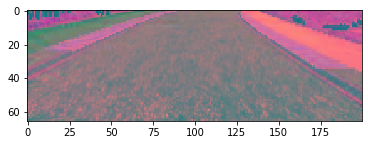

Imagen aleatoria del conjunto de validación:


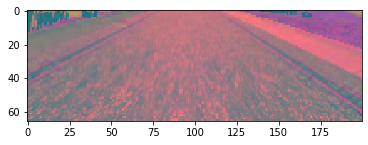

Creación del modelo de NVIDIA...

El modelo de NVIDIA se ha creado correctamente.

Estructura del modelo creado:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_____________________________

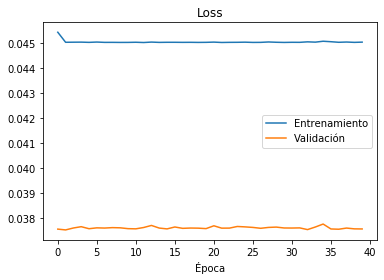

In [20]:
prueba6(dataset_preprocesado, 40, 100)

## Prueba 7: Entrenamiento del modelo LeNet-5

In [21]:
#Prerrequisitos: dataset con preprocesamiento básico
num_bins = 23
max_muestras_por_bin = 300

dataset = lee_csv()
datos_renombrados = renombra_imagenes(dataset)
hist, bins = genera_histograma(datos_renombrados, num_bins)

dataset_preprocesado = balancea_dataset(datos_renombrados, num_bins, bins, max_muestras_por_bin)

In [22]:
def prueba7(dataset_preprocesado, epochs, batch_size):
    print("--Prueba 7: Entrenamiento del modelo LeNet-5--\n")
    
    try:
        print("Obtención de las imágenes y sus ángulos del dataset...\n")
        imgs, angulos = get_imgs_y_angulos(dataset_preprocesado)
    except:
        print("Error al obtener las imágenes y sus ángulos.")
        raise
    print("Las imágenes y sus ángulos se han leído correctamente.")
    
    try:
        print("\nDivisión del dataset en conjuntos de entrenamiento (80%) y validación (20%)...\n")
        x_entrenamiento, x_test, y_entrenamiento, y_test = divide_dataset(imgs, angulos)
    except:
        print("Error al dividir el dataset.")
        raise
    print("División realizada correctamente.\n")
    
    tamano_dataset = len(dataset_preprocesado)
    tamano_entrenamiento = len(x_entrenamiento)
    tamano_validacion = len(x_test)
    print("Tamaño del dataset antes de dividirse: {}".format(tamano_dataset))
    print("\nTamaño del subconjunto de entrenamiento: {}, un {}%".format(tamano_entrenamiento, 
                                                                         round((tamano_entrenamiento/tamano_dataset) * 100)))
    print("\nTamaño del subconjunto de validación: {}, un {}%".format(tamano_validacion, 
                                                                      round((tamano_validacion/tamano_dataset) * 100)))
    
    try:
        print("\nPreprocesamiento de las imágenes de ambos conjuntos para adaptarlas a los requisitos del modelo de LeNet-5...\n")
        x_entrenamiento, x_test = preproceso_dataset_lenet5(x_entrenamiento, x_test)
    except:
        print("Error al preprocesar todas las imágenes.")
        raise
    print("Preprocesamiento de imágenes realizado correctamente.\n")
    
    try:
        print("Muestra del procesamiento realizado sobre una imagen al azar en ambos conjuntos...\n")
        num_random_entrenamiento = random.randrange(0, len(x_entrenamiento))
        num_random_validacion = random.randrange(0, len(x_test))
        img_entrenamiento = x_entrenamiento[num_random_entrenamiento]
        img_validacion = x_test[num_random_validacion]
        
        print("Imagen aleatoria del conjunto de entrenamiento:")
        
        #A las imágenes con un solo canal hay que eliminarles la tercera dimensión para que se puedan mostrar correctamente
        plt.imshow(img_entrenamiento[:,:,0], cmap='gray') 
        plt.show()
        
        print("Imagen aleatoria del conjunto de validación:")
        plt.imshow(img_validacion[:,:,0], cmap='gray')
        plt.show()
    except:
        print("Error al seleccionar o mostrar la imagen.")
        raise
        
    try:
        print("Creación del modelo de LeNet-5...\n")
        modelo = crea_modelo_lenet5()
    except:
        print("Error al crear el modelo.")
        raise
    print("El modelo de LeNet-5 se ha creado correctamente.")
    
    print("\nEstructura del modelo creado:")
    print(modelo.summary())
    
    try:
        print("\nEntrenamiento del modelo...\n")
        print("Número de épocas elegidas: {}. Batch_size: {}\n".format(epochs, batch_size))
        entrenamiento = entrena_modelo(modelo, x_entrenamiento, y_entrenamiento, x_test, y_test, epochs, batch_size)
    except:
        print("Error al entrenar el modelo.")
        raise
    print("\nEl modelo de LeNet-5 se ha entrenado correctamente.")
    
    try:
        print("\nValores de loss del modelo...\n")
        representa_loss(entrenamiento)
    except:
        print("Error al representar la gráfica.")
        raise

--Prueba 7: Entrenamiento del modelo LeNet-5--

Obtención de las imágenes y sus ángulos del dataset...

Las imágenes y sus ángulos se han leído correctamente.

División del dataset en conjuntos de entrenamiento (80%) y validación (20%)...

División realizada correctamente.

Tamaño del dataset antes de dividirse: 2192

Tamaño del subconjunto de entrenamiento: 1753, un 80%

Tamaño del subconjunto de validación: 439, un 20%

Preprocesamiento de las imágenes de ambos conjuntos para adaptarlas a los requisitos del modelo de LeNet-5...

Preprocesamiento de imágenes realizado correctamente.

Muestra del procesamiento realizado sobre una imagen al azar en ambos conjuntos...

Imagen aleatoria del conjunto de entrenamiento:


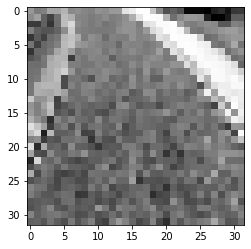

Imagen aleatoria del conjunto de validación:


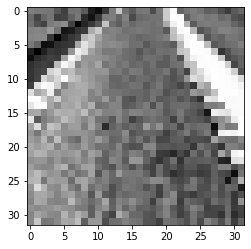

Creación del modelo de LeNet-5...

El modelo de LeNet-5 se ha creado correctamente.

Estructura del modelo creado:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_4 (Flatten)          (None, 120)               0         
___________________________

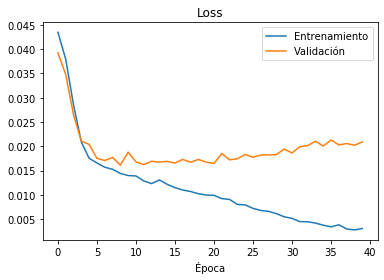

In [23]:
prueba7(dataset_preprocesado, 40, 100)